In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
from baal.bayesian.dropout import unpatch_module

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
)  

In [7]:
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

# Abortion

In [29]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [30]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [31]:
active_mc_abortion1= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = model_original
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion1.append(performance_history_abortion)
    mcrun = mcrun + 1

[123 365 578]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:20.195236Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 34.03it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:24.315489Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 36.23it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:28.434816Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 36.58it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:32.702922Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.02it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:37.241147Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 36.76it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:41.928883Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.74it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:46.794195Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.87it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:51.722017Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.71it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:49:56.825844Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.68it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:02.210814Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.42it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:07.756120Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.15it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:13.503755Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 38.17it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:19.531024Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 36.39it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:25.674656Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 38.11it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:32.065943Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 37.70it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:38.304932Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 38.20it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:44.793310Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.96it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:52.580842Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 37.49it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:50:59.588071Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.32it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:06.815696Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 38.18it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:14.146321Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.57it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:21.549114Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 38.06it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:29.260383Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 37.65it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:37.279139Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.92it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:45.364035Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.94it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:51:53.656890Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.80it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:01.908200Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.59it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:10.410171Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 40.38it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:19.363591Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.34it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:28.798370Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


[0.17142857142857143, 0.17142857142857143, 0.16785714285714284, 0.16785714285714284, 0.16071428571428573, 0.16785714285714284, 0.16785714285714284, 0.18928571428571428, 0.26071428571428573, 0.32857142857142857, 0.34285714285714286, 0.5678571428571428, 0.5285714285714286, 0.6714285714285714, 0.6392857142857142, 0.6714285714285714, 0.6464285714285715, 0.675, 0.6714285714285714, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:32.108741Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 36.85it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:35.993236Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 34.53it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:40.422329Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.34it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:44.744660Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.32it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:49.145391Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.21it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:53.624516Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.21it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:52:58.431139Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.34it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:03.446755Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 38.86it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:08.501666Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.60it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:13.926779Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 38.91it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:19.414424Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 38.06it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:25.168528Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 35.70it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:31.208949Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.87it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:37.333670Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 36.39it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:43.460902Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.88it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:49.784332Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 38.16it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:53:56.395907Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 38.05it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:03.231229Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 38.72it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:10.393402Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.52it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:17.472709Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 39.30it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:24.671724Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.65it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:32.161494Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 39.49it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:39.949748Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.06it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:47.865963Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.77it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:54:56.037718Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.91it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:04.059262Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.26it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:12.505602Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.88it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:21.063361Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.11it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:30.199096Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.84it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:39.104906Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.51it/s]


[0.16785714285714284, 0.16785714285714284, 0.17857142857142858, 0.175, 0.18928571428571428, 0.20357142857142857, 0.23214285714285715, 0.3535714285714286, 0.35, 0.45714285714285713, 0.43214285714285716, 0.6107142857142858, 0.6035714285714285, 0.6107142857142858, 0.6678571428571428, 0.6714285714285714, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:42.315912Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 36.10it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:46.764106Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 36.70it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:50.835194Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.52it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:55.005433Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.19it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:55:59.593430Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.74it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:04.356602Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 36.32it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:09.697595Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.65it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:14.670059Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.20it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:19.852397Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.65it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:25.210621Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.35it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:30.802879Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.37it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:36.529520Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 37.34it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:42.444281Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.56it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:48.724983Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 37.88it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:56:55.116146Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.76it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:01.650560Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 37.60it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:08.306093Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 36.52it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:15.076838Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 38.71it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:22.136972Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.97it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:29.156065Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 35.87it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:36.647554Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.33it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:44.770528Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 36.51it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:57:52.601930Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 38.05it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:00.542982Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.26it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:08.744014Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.30it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:17.290217Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.44it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:25.968570Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.68it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:34.900513Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.32it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:43.875558Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.62it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:52.912734Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.83it/s]


[0.16785714285714284, 0.16785714285714284, 0.17857142857142858, 0.175, 0.18928571428571428, 0.20357142857142857, 0.23214285714285715, 0.3535714285714286, 0.35, 0.45714285714285713, 0.43214285714285716, 0.6107142857142858, 0.6035714285714285, 0.6107142857142858, 0.6678571428571428, 0.6714285714285714, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:58:56.378405Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 36.63it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:00.317397Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 36.64it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:04.455921Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 35.85it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:08.801393Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.23it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:13.300862Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.14it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:17.898397Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 36.95it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:22.892335Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.74it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:27.948220Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.57it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:33.250969Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.49it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:38.805967Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.09it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:44.424300Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.88it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:50.242227Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 36.56it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T16:59:57.886670Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.22it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:04.080105Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 38.19it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:10.535962Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 37.06it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:18.324691Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 37.88it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:25.069006Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.63it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:31.783014Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 36.76it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:38.911264Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 37.64it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:46.182374Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 38.02it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:00:53.619806Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.83it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:01.188826Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.64it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:09.083524Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.11it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:16.926950Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.30it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:25.243842Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.96it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:33.582016Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.81it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:42.214658Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32.67it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:01:51.054807Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.85it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:00.068423Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.98it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:09.034667Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s]


[0.16785714285714284, 0.16785714285714284, 0.17857142857142858, 0.175, 0.18928571428571428, 0.20357142857142857, 0.23214285714285715, 0.3535714285714286, 0.35, 0.45714285714285713, 0.43214285714285716, 0.6107142857142858, 0.6035714285714285, 0.6107142857142858, 0.6678571428571428, 0.6714285714285714, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:12.468393Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 36.77it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:16.417225Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 37.42it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:20.819780Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.44it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:25.599183Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.72it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:30.119632Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.32it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:34.729604Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.15it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:39.680768Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 35.98it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:44.773139Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.42it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:50.037912Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.96it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:02:56.372841Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.38it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:02.048632Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.79it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:09.790242Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 37.53it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:15.775776Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.17it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:21.961133Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 38.23it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:28.324438Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.68it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:34.857001Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 38.05it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:41.549246Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 38.00it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:48.466287Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 37.92it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:03:55.572763Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.87it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:02.838297Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 37.29it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:10.346485Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.00it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:17.963490Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 38.35it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:25.545652Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.32it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:33.481733Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.31it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:41.723203Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.61it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:50.093426Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.88it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:04:58.657256Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.17it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:07.415457Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.33it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:16.204110Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.84it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:25.365554Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]


[0.16785714285714284, 0.16785714285714284, 0.17857142857142858, 0.175, 0.18928571428571428, 0.20357142857142857, 0.23214285714285715, 0.3535714285714286, 0.35, 0.45714285714285713, 0.43214285714285716, 0.6107142857142858, 0.6035714285714285, 0.6107142857142858, 0.6678571428571428, 0.6714285714285714, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


In [32]:
median_abortion1, min_abortion1,max_abortion1 = calculate(active_mc_abortion1)

In [33]:
active_mc_abortion2= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion2.append(performance_history_abortion)
    mcrun = mcrun + 1

[  9 541 129]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:28.782760Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.20it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:33.196050Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 27.34it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:38.214179Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.59it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:44.017307Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:48.841579Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.36it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:53.847223Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.96it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:05:58.935536Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.37it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:04.078237Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.98it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:09.538183Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.94it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:15.037122Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 35.16it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:20.797505Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.79it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:26.647007Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 34.95it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:32.709215Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:39.131123Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.17it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:45.746601Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:52.611309Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:06:59.591258Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.49it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:06.656582Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.64it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:13.878588Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.08it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:21.257564Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.68it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:28.728094Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:36.394071Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.72it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:44.249291Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 32.86it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:07:52.537030Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:00.918474Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.11it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:09.247637Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.46it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:18.221584Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.55it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:27.723257Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.61it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:38.664486Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.31it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:49.027757Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


[0.21785714285714286, 0.19285714285714287, 0.21071428571428572, 0.26785714285714285, 0.30714285714285716, 0.3464285714285714, 0.3964285714285714, 0.4107142857142857, 0.4392857142857143, 0.5357142857142857, 0.5, 0.6142857142857143, 0.55, 0.6285714285714286, 0.6714285714285714, 0.6678571428571428, 0.6785714285714286, 0.6642857142857143, 0.6714285714285714, 0.675, 0.6678571428571428, 0.6714285714285714, 0.675, 0.675, 0.6785714285714286, 0.675, 0.6714285714285714, 0.675, 0.675, 0.6714285714285714, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:52.489467Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.32it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:08:56.733971Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.71it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:01.062155Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.70it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:05.599444Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:10.544533Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.83it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:16.229870Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.61it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:21.521399Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.83it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:26.894026Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 34.15it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:32.679038Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:38.402811Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.46it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:44.328154Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.24it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:50.962335Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:09:57.410112Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.10it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:03.800337Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.70it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:10.376550Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.12it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:17.233479Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.49it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:24.349636Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:31.494093Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.36it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:38.978349Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.07it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:46.755213Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.69it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:10:54.354117Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.88it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:02.036380Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.90it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:10.004600Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:18.112902Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31.35it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:26.491491Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.45it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:34.953894Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:45.155873Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.45it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:11:54.213688Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.12it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:03.171191Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34.20it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:12.221867Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.29it/s]


[0.225, 0.19285714285714287, 0.23214285714285715, 0.325, 0.375, 0.3535714285714286, 0.32857142857142857, 0.4392857142857143, 0.4714285714285714, 0.475, 0.5107142857142857, 0.5607142857142857, 0.55, 0.6357142857142857, 0.6321428571428571, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:15.617124Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.22it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:19.791658Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.58it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:24.201997Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.80it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:28.994427Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.47it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:33.658506Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.90it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:38.714132Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:43.876407Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.75it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:49.119014Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:12:54.563436Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:00.220971Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:06.099870Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.50it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:12.088877Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 34.31it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:18.093919Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:24.489158Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.04it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:31.110618Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:37.753987Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:44.618510Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.26it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:13:51.560421Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.66it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:00.226843Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:07.535728Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.38it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:15.130217Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.99it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:22.756553Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.77it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:30.560678Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.77it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:38.649394Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.79it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:46.903951Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.65it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:14:55.355491Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.62it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:04.040091Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.13it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:12.722390Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.54it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:21.583090Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:30.755446Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.18it/s]


[0.225, 0.19285714285714287, 0.23214285714285715, 0.325, 0.375, 0.3535714285714286, 0.32857142857142857, 0.4392857142857143, 0.4714285714285714, 0.475, 0.5107142857142857, 0.5607142857142857, 0.55, 0.6357142857142857, 0.6321428571428571, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:34.206102Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.45it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:38.412640Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.57it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:42.833939Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.44it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:47.327238Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.30it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:52.119139Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.08it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:15:57.149804Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.72it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:02.338095Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.74it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:07.549975Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.90it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:13.093408Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:18.652551Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.90it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:24.723627Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.80it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:30.668418Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.38it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:36.729768Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.77it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:43.113191Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:49.724168Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.60it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:16:56.440067Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.97it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:03.368588Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:10.451419Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.99it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:17.738548Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.41it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:25.217119Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.65it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:32.690371Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.66it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:40.400754Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.59it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:48.304559Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.36it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:17:56.440315Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:04.831576Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.56it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:13.260509Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.30it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:21.955171Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.05it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:30.732408Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.43it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:39.707917Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.55it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:48.793775Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.69it/s]


[0.225, 0.19285714285714287, 0.23214285714285715, 0.325, 0.375, 0.3535714285714286, 0.32857142857142857, 0.4392857142857143, 0.4714285714285714, 0.475, 0.5107142857142857, 0.5607142857142857, 0.55, 0.6357142857142857, 0.6321428571428571, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:52.165323Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.32it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:18:56.357664Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.85it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:00.750478Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.91it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:05.206005Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.75it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:10.090986Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:15.034167Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 34.14it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:20.171300Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:25.542912Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:31.097758Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.24it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:36.653417Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 34.62it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:42.521225Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.44it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:48.743037Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:19:54.808906Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:01.166343Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.96it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:07.750993Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.43it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:14.349020Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.31it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:21.371164Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:28.213385Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 35.12it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:35.421899Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:42.675118Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.55it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:50.225630Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.49it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:20:57.837330Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 35.30it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:05.673018Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.40it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:13.762675Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.70it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:22.137947Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.70it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:30.640735Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.01it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:39.121595Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.82it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:47.685737Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.95it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:21:56.549457Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.72it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T17:22:05.552779Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.32it/s]


[0.225, 0.19285714285714287, 0.23214285714285715, 0.325, 0.375, 0.3535714285714286, 0.32857142857142857, 0.4392857142857143, 0.4714285714285714, 0.475, 0.5107142857142857, 0.5607142857142857, 0.55, 0.6357142857142857, 0.6321428571428571, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675]


In [34]:
median_abortion2, min_abortion2,max_abortion2 = calculate(active_mc_abortion2)

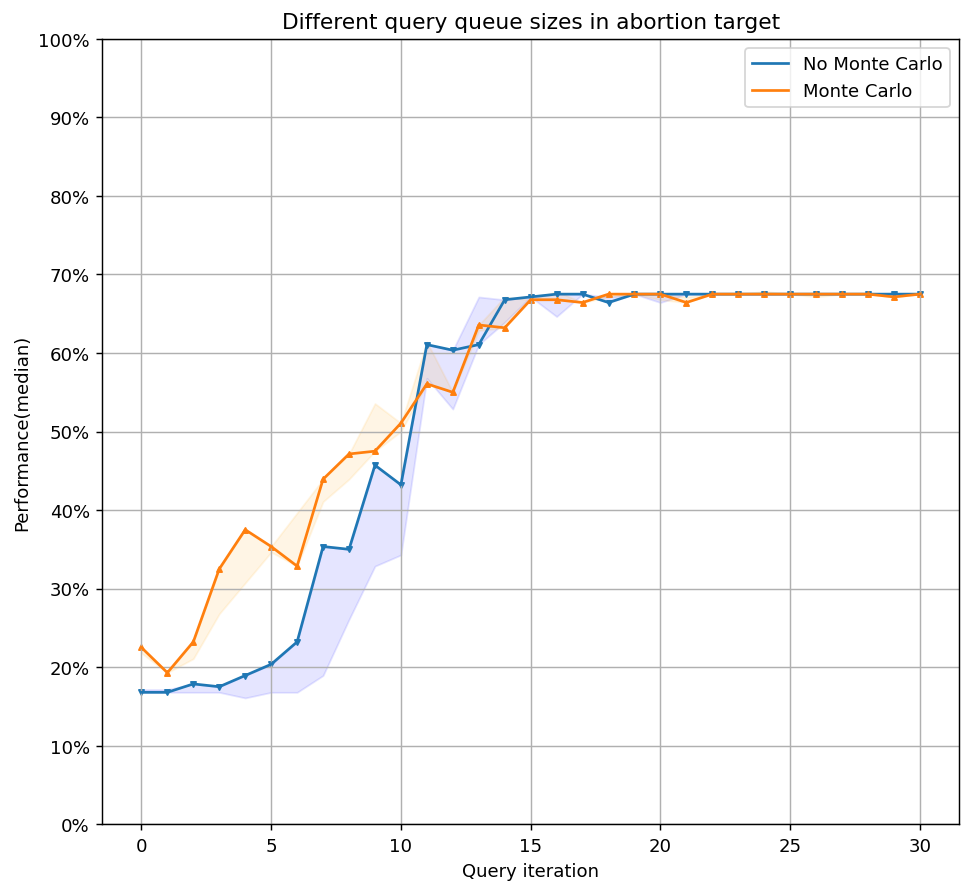

In [35]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_abortion1,label="No Monte Carlo")
ax.fill_between(range(31),min_abortion1,max_abortion1,color='blue', alpha=0.1)
ax.plot(median_abortion2,label="Monte Carlo")
ax.fill_between(range(31),min_abortion2,max_abortion2,color='orange', alpha=0.1)

ax.scatter(range(31), median_abortion1, s=8,marker = "v")
ax.scatter(range(31), median_abortion2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in abortion target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Atheism

In [15]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_atheism)} instances loaded")

val_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_atheism)} instances loaded")

test_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_atheism)} instances loaded")

num_classes = np.unique(train_dataset_atheism['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 461 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 52 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 220 instances loaded


In [16]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [17]:
active_mc_atheism1 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_atheism['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = model_original
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
    print(performance_history_atheism)
    active_mc_atheism1.append(performance_history_atheism)
    mcrun = mcrun + 1

[ 93  25 239]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:24.144238Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.28it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:27.290733Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 36.65it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:31.000679Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.64it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:34.993274Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.79it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:38.832356Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 38.24it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:43.519412Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 36.90it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:49.323950Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 38.14it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:53.559958Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.45it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:55:57.979804Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 30.97it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:03.501139Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.48it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:08.528069Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.48it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:13.549518Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.05it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:18.661156Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 37.22it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:23.986590Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.26it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:30.151315Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.84it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:36.565062Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.34it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:42.692176Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 39.36it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:48.671760Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.96it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:56:56.097504Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.77it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:02.852985Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.11it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:09.474647Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.19it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:16.295096Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.26it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:24.214851Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 46.99it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.16363636363636364, 0.16363636363636364, 0.20454545454545456, 0.2636363636363636, 0.33181818181818185, 0.4636363636363636, 0.5772727272727273, 0.6772727272727272, 0.7136363636363636, 0.7181818181818181, 0.7272727272727273, 0.7181818181818181, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:34.550312Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.56it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:37.810746Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.67it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:41.587190Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.85it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:45.820583Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.48it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:49.682079Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.54it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:54.171390Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 29.50it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:57:58.969293Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.02it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:03.295546Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.29it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:08.198579Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.06it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:13.390589Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.38it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:18.165614Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.58it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:23.138617Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.11it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:29.631232Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.06it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:34.978720Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.96it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:41.221010Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.07it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:46.874099Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.94it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:53.385794Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.70it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:58:59.321306Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.10it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:05.558919Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:13.297499Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.30it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:20.174315Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.59it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:28.028084Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.27it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:34.978901Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.61it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.14545454545454545, 0.14545454545454545, 0.15454545454545454, 0.19545454545454546, 0.2727272727272727, 0.4, 0.4590909090909091, 0.6318181818181818, 0.6227272727272727, 0.6909090909090909, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:45.548602Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.90it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:48.906004Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 30.34it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:52.977944Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.38it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T14:59:56.557662Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.49it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:00.772097Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.12it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:04.870790Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 37.18it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:09.563685Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.85it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:13.965337Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.27it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:18.419743Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.16it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:23.904376Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 30.94it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:29.003472Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 38.65it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:33.988219Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.48it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:39.663715Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.45it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:45.726108Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.12it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:51.242336Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.72it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:00:57.036231Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.06it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:04.155120Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.95it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:10.452188Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.27it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:17.271476Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.08it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:23.799920Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.12it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:30.849868Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.49it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:37.753522Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.82it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:45.805027Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.18it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.14545454545454545, 0.14545454545454545, 0.15454545454545454, 0.19545454545454546, 0.2727272727272727, 0.4, 0.4590909090909091, 0.6318181818181818, 0.6227272727272727, 0.6909090909090909, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:55.353556Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 30.38it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:01:59.120005Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 29.36it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:03.227716Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.38it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:07.401556Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.62it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:11.268862Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.02it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:15.673424Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 30.65it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:20.385920Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 36.79it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:24.626055Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.13it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:29.872499Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.16it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:35.146265Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 31.08it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:40.442184Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:45.396227Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.91it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:51.447733Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.42it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:02:57.105527Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.51it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:02.649960Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.85it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:08.346946Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.40it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:15.228325Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 29.98it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:21.852607Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.41it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:28.206016Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.71it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:35.635212Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.88it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:42.162144Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.03it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:50.021077Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.98it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:03:56.988725Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.64it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.14545454545454545, 0.14545454545454545, 0.15454545454545454, 0.19545454545454546, 0.2727272727272727, 0.4, 0.4590909090909091, 0.6318181818181818, 0.6227272727272727, 0.6909090909090909, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:07.611433Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 38.11it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:10.621308Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 30.06it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:14.568245Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.57it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:18.434906Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.35it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:22.421675Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 30.39it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:27.206915Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 29.90it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:31.838195Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.94it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:36.088713Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.63it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:41.071757Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 31.15it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:46.131719Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.42it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:51.652249Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.41it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:04:56.898884Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.07it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:02.140105Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.37it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:08.327272Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 30.70it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:14.151269Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.98it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:20.515216Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.00it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:26.458592Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 37.62it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:32.655727Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.79it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:39.010116Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.57it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:46.586838Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.00it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:05:53.234924Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.18it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:00.672333Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.81it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:08.546811Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.65it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.14545454545454545, 0.14545454545454545, 0.15454545454545454, 0.19545454545454546, 0.2727272727272727, 0.4, 0.4590909090909091, 0.6318181818181818, 0.6227272727272727, 0.6909090909090909, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [18]:
median_atheism1, min_atheism1,max_atheism1 = calculate(active_mc_atheism1)

In [19]:
active_mc_atheism2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_atheism['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
    print(performance_history_atheism)
    active_mc_atheism2.append(performance_history_atheism)
    mcrun = mcrun + 1

[332  15 230]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:18.701381Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.29it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:22.238284Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 26.93it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:26.610538Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.51it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:31.202154Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.03it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:35.260482Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:39.826956Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 27.30it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:44.853805Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:49.441069Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:06:54.036746Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 31.94it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:00.206818Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 26.57it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:06.576118Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 27.12it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:12.983647Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.34it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:18.909034Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 26.92it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:25.342800Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.91it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:31.030924Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.12it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:37.707465Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.45it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:44.076473Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.56it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:50.495405Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 27.49it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:07:57.712862Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:04.265588Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:12.276319Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.21it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:19.248290Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:26.684369Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.11it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.21363636363636362, 0.17727272727272728, 0.2409090909090909, 0.2318181818181818, 0.2909090909090909, 0.37272727272727274, 0.45, 0.5454545454545454, 0.6090909090909091, 0.6, 0.6545454545454545, 0.7045454545454546, 0.7136363636363636, 0.7227272727272728, 0.7181818181818181, 0.7136363636363636, 0.7227272727272728, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7318181818181818]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:37.920658Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:41.573092Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 27.20it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:45.902130Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.76it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:49.765542Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.02it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:54.582373Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.07it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:08:58.643245Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.13it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:04.035685Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:08.777963Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.49it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:13.993398Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:18.828534Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.97it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:24.041236Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 27.29it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:30.323274Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.51it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:35.652638Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.94it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:41.185853Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.64it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:46.874370Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.60it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:09:53.855530Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.53it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:00.207614Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 32.93it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:06.411796Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.02it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:13.376035Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 28.37it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:21.295957Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.31it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:28.235421Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.70it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:35.144408Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.31it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:43.141864Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.14it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.16818181818181818, 0.15, 0.18181818181818182, 0.18181818181818182, 0.29545454545454547, 0.33181818181818185, 0.4090909090909091, 0.5181818181818182, 0.5818181818181818, 0.5863636363636363, 0.6363636363636364, 0.6636363636363637, 0.7045454545454546, 0.7227272727272728, 0.6818181818181818, 0.7090909090909091, 0.7090909090909091, 0.7318181818181818, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:53.766336Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 29.46it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:10:57.715906Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 30.97it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:01.457589Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.66it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:05.625762Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.80it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:10.390136Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.23it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:14.448940Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.87it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:18.794994Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.13it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:23.872675Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.08it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:29.196664Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.23it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:34.070987Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:39.582285Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 27.37it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:45.258331Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.89it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:50.627132Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:11:57.029663Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.59it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:03.461542Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.05it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:09.285666Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.49it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:15.138177Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 29.81it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:22.547455Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.44it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:29.400947Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.53it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:36.272357Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.32it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:43.497787Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.12it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:50.660102Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.87it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:12:58.511949Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.15it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.16818181818181818, 0.15, 0.18181818181818182, 0.18181818181818182, 0.29545454545454547, 0.33181818181818185, 0.4090909090909091, 0.5181818181818182, 0.5818181818181818, 0.5863636363636363, 0.6363636363636364, 0.6636363636363637, 0.7045454545454546, 0.7227272727272728, 0.6818181818181818, 0.7090909090909091, 0.7090909090909091, 0.7318181818181818, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:08.329703Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 30.26it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:12.224665Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 26.83it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:16.593691Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.18it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:20.761569Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.73it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:24.816311Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:29.009442Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.89it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:33.960275Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 27.46it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:39.415244Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.99it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:44.189829Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.53it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:49.796428Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 31.85it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:13:54.988199Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.71it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:00.241281Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:06.491475Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 27.58it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:12.341533Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:18.288022Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.11it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:24.855425Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:31.141950Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.38it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:37.411796Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 32.08it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:44.913913Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.42it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:51.393990Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.20it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:14:59.503293Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 31.05it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:06.500657Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.42it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:14.420303Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.57it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.16818181818181818, 0.15, 0.18181818181818182, 0.18181818181818182, 0.29545454545454547, 0.33181818181818185, 0.4090909090909091, 0.5181818181818182, 0.5818181818181818, 0.5863636363636363, 0.6363636363636364, 0.6636363636363637, 0.7045454545454546, 0.7227272727272728, 0.6818181818181818, 0.7090909090909091, 0.7090909090909091, 0.7318181818181818, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:24.671155Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.65it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:28.884689Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 26.97it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:33.307656Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 31.38it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:37.037888Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.15it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:41.558585Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:45.784094Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.24it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:50.723218Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 31.98it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:15:55.393213Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.82it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:00.726033Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.85it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:05.599748Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:11.397902Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.12it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:16.711271Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.63it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:22.893280Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:28.492145Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:34.306203Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:40.418388Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.23it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:47.600841Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:16:53.803574Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 27.81it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:17:01.108888Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.11it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:17:07.609206Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.65it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:17:15.447009Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.15it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:17:23.060225Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.08it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[17944-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-06T15:17:30.561887Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.42it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.16818181818181818, 0.15, 0.18181818181818182, 0.18181818181818182, 0.29545454545454547, 0.33181818181818185, 0.4090909090909091, 0.5181818181818182, 0.5818181818181818, 0.5863636363636363, 0.6363636363636364, 0.6636363636363637, 0.7045454545454546, 0.7227272727272728, 0.6818181818181818, 0.7090909090909091, 0.7090909090909091, 0.7318181818181818, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273]


In [20]:
median_atheism2, min_atheism2,max_atheism2 = calculate(active_mc_atheism2)

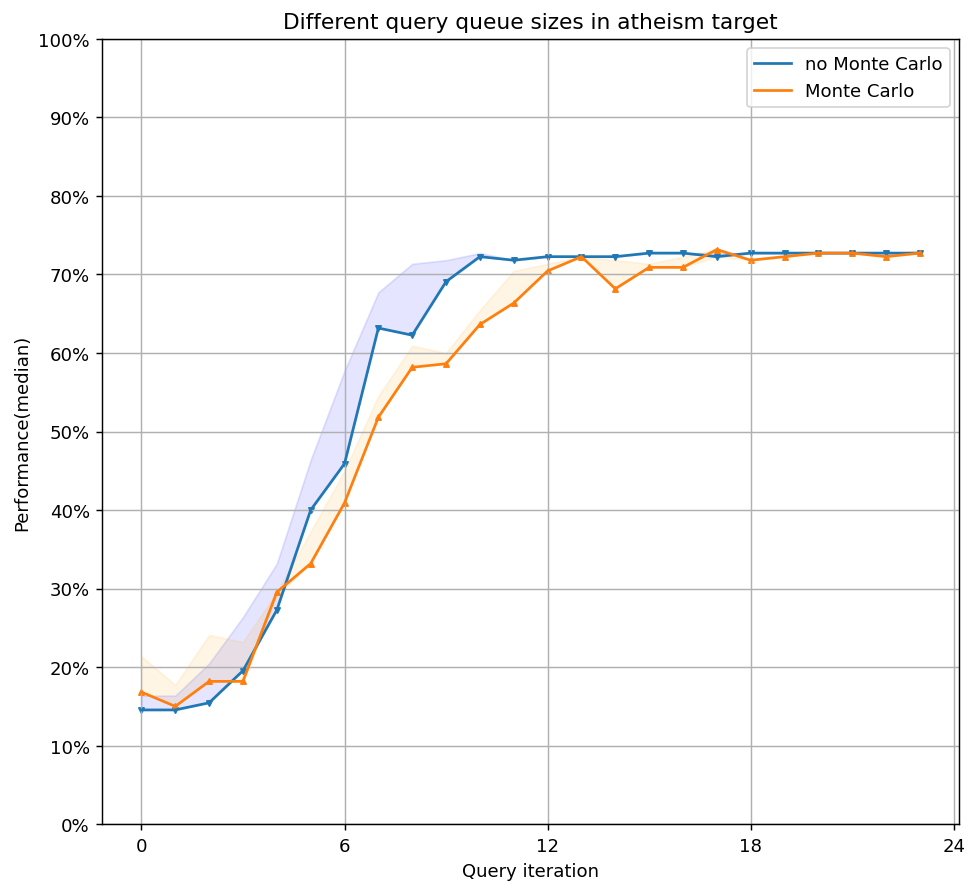

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_atheism1,label="no Monte Carlo")
ax.fill_between(range(24),min_atheism1,max_atheism1,color='blue', alpha=0.1)
ax.plot(median_atheism2,label="Monte Carlo")
ax.fill_between(range(24),min_atheism2,max_atheism2,color='orange', alpha=0.1)

ax.scatter(range(24), median_atheism1, s=8,marker = "v")
ax.scatter(range(24), median_atheism2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in atheism target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Climate

In [21]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_climate)} instances loaded")

val_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_climate)} instances loaded")

test_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_climate)} instances loaded")

num_classes = np.unique(train_dataset_climate['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 355 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 40 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 169 instances loaded


In [22]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [25]:
active_mc_climate1= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_climate['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = model_original
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
    print(performance_history_climate)
    active_mc_climate1.append(performance_history_climate)
    mcrun = mcrun + 1

[137 302 161]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:42.154050Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 39.97it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:44.624863Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 37.30it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:47.467880Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.14it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:50.325514Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 40.39it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:53.406252Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 38.86it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:27:56.797230Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.36it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:01.285229Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.36it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:05.530968Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 41.28it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:09.172992Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.02it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:14.442633Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 39.71it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:18.479638Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.76it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:22.650660Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 40.96it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:26.863707Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.65it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:31.260091Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.70it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:35.837213Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.00it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:41.029216Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 40.94it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:45.953141Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.48it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:51.983176Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 38.46it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.0650887573964497, 0.0650887573964497, 0.0650887573964497, 0.05917159763313609, 0.05917159763313609, 0.10059171597633136, 0.14792899408284024, 0.35502958579881655, 0.4970414201183432, 0.6745562130177515, 0.5384615384615384, 0.6745562130177515, 0.5562130177514792, 0.7337278106508875, 0.6331360946745562, 0.6153846153846154, 0.727810650887574, 0.6863905325443787, 0.727810650887574]
[335 117 232]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:28:59.999086Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 38.26it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:02.433084Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 40.78it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:04.952149Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.92it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:07.626193Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 40.70it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:10.487320Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 36.52it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:13.568319Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.75it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:16.799321Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:21.134455Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.91it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:25.131277Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.46it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:29.037274Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.42it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:33.250274Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.94it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:37.348240Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 35.64it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:42.040786Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 37.43it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:46.563805Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:51.261999Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.29it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:29:56.509987Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.18it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:02.318985Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.99it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:08.212807Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.0650887573964497, 0.0650887573964497, 0.05917159763313609, 0.07100591715976332, 0.08284023668639054, 0.11834319526627218, 0.24260355029585798, 0.3727810650887574, 0.5443786982248521, 0.650887573964497, 0.591715976331361, 0.6272189349112426, 0.727810650887574, 0.6272189349112426, 0.727810650887574, 0.6331360946745562, 0.6982248520710059, 0.6272189349112426, 0.7159763313609467]
[335 117 232]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:16.017938Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 38.00it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:18.427753Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 39.22it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:21.085754Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.59it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:23.737847Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 39.53it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:26.686848Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 40.14it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:29.895878Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.09it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:33.329850Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 35.19it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:36.894849Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.46it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:41.119577Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:45.288603Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.23it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:49.436614Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.18it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:53.561613Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 39.08it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:30:58.063131Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:02.611857Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.96it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:07.398889Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 38.63it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:12.469333Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 43.48it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:17.531370Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:22.986375Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.0650887573964497, 0.0650887573964497, 0.05917159763313609, 0.07100591715976332, 0.08284023668639054, 0.11834319526627218, 0.24260355029585798, 0.3727810650887574, 0.5443786982248521, 0.650887573964497, 0.591715976331361, 0.6272189349112426, 0.727810650887574, 0.6272189349112426, 0.727810650887574, 0.6331360946745562, 0.6982248520710059, 0.6272189349112426, 0.7159763313609467]
[335 117 232]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:30.313518Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 40.70it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:32.692552Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 40.04it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:35.327595Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.00it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:37.925593Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 41.43it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:40.714595Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 40.62it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:43.784870Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.11it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:47.031870Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 40.90it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:50.393873Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.09it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:54.025875Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.80it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:31:57.787869Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.91it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:01.803039Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.92it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:06.474416Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.36it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:12.579608Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.04it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:17.347892Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.27it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:22.094796Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 38.96it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:26.990989Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 42.42it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:32.068510Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.82it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:37.331566Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.28it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.0650887573964497, 0.0650887573964497, 0.05917159763313609, 0.07100591715976332, 0.08284023668639054, 0.11834319526627218, 0.24260355029585798, 0.3727810650887574, 0.5443786982248521, 0.650887573964497, 0.591715976331361, 0.6272189349112426, 0.727810650887574, 0.6272189349112426, 0.727810650887574, 0.6331360946745562, 0.6982248520710059, 0.6272189349112426, 0.7159763313609467]
[335 117 232]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:48.653694Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 36.97it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:52.494578Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 39.74it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:56.365727Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.94it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:32:59.947839Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 39.23it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:07.016191Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 36.40it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:11.958849Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.12it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:15.769597Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 38.67it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:20.603127Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 39.42it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:25.607994Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 40.40it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:31.679711Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.31it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:37.332441Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.95it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:41.596987Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.77it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:46.458038Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.65it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:51.622037Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:33:57.138037Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 38.46it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:05.838075Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 40.46it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:11.493866Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 44.94it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:19.477632Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.80it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.0650887573964497, 0.0650887573964497, 0.05917159763313609, 0.07100591715976332, 0.08284023668639054, 0.11834319526627218, 0.24260355029585798, 0.3727810650887574, 0.5443786982248521, 0.650887573964497, 0.591715976331361, 0.6272189349112426, 0.727810650887574, 0.6272189349112426, 0.727810650887574, 0.6331360946745562, 0.6982248520710059, 0.6272189349112426, 0.7159763313609467]


In [26]:
median_climate1, min_climate1,max_climate1 = calculate(active_mc_climate1)

In [27]:
active_mc_climate2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_climate['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
    print(performance_history_climate)
    active_mc_climate2.append(performance_history_climate)
    mcrun = mcrun + 1

[203  82  64]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:27.125170Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.05it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:29.909736Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.83it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:32.973737Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.82it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:37.642659Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.63it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:41.532653Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 30.38it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:45.445650Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.32it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:48.948771Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 36.29it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:52.749918Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 36.94it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:34:56.445470Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.17it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:00.521468Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.24it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:04.706268Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 36.54it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:09.066804Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 35.64it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:13.803790Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.34it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:19.143791Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:23.913072Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.29it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:28.909556Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.89it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:34.525054Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:39.656615Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 45.43it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.05917159763313609, 0.0650887573964497, 0.07100591715976332, 0.08284023668639054, 0.07100591715976332, 0.21893491124260356, 0.24260355029585798, 0.3431952662721893, 0.5088757396449705, 0.5562130177514792, 0.5976331360946746, 0.5502958579881657, 0.5798816568047337, 0.5562130177514792, 0.650887573964497, 0.7218934911242604, 0.6627218934911243, 0.650887573964497, 0.7337278106508875]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:48.158732Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.95it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:52.083802Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 35.87it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:56.592032Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.51it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:35:59.574033Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.20it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:02.864030Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 30.74it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:07.652511Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.08it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:11.655503Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.37it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:15.615498Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:20.204552Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.31it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:25.743375Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.26it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:32.062514Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:36.375212Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.85it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:41.071454Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.17it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:45.819754Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.99it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:50.755904Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.88it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:36:55.673845Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.28it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:00.866607Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:06.143621Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.05917159763313609, 0.07100591715976332, 0.07100591715976332, 0.07100591715976332, 0.07692307692307693, 0.1952662721893491, 0.2485207100591716, 0.3609467455621302, 0.4260355029585799, 0.5680473372781065, 0.5621301775147929, 0.4970414201183432, 0.5088757396449705, 0.5798816568047337, 0.6863905325443787, 0.7218934911242604, 0.6982248520710059, 0.6153846153846154, 0.727810650887574]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:13.781105Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.24it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:16.444105Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.33it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:19.338503Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.97it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:22.200941Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 36.78it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:25.335639Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34.55it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:32.619062Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.83it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:36.078212Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 36.45it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:40.979899Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.97it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:44.874495Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.98it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:48.709082Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.17it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:52.681623Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 38.15it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:37:56.801876Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 38.29it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:01.186533Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.65it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:05.653069Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:10.813068Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.70it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:15.565190Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.00it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:20.824685Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.55it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:26.500451Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.45it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.05917159763313609, 0.07100591715976332, 0.07100591715976332, 0.07100591715976332, 0.07692307692307693, 0.1952662721893491, 0.2485207100591716, 0.3609467455621302, 0.4260355029585799, 0.5680473372781065, 0.5621301775147929, 0.4970414201183432, 0.5088757396449705, 0.5798816568047337, 0.6863905325443787, 0.7218934911242604, 0.6982248520710059, 0.6153846153846154, 0.727810650887574]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:34.304726Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.89it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:36.891259Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.48it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:39.723788Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.03it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:42.954057Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 35.37it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:46.156426Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 36.74it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:49.228923Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.22it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:52.768408Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.34it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:38:56.630999Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.34it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:00.406028Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.14it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:04.542127Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:08.783754Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:13.681218Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 22.64it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:19.586046Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.57it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:24.752288Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.09it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:29.966249Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 29.51it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:35.401722Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.98it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:40.923588Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:48.088093Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.98it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.05917159763313609, 0.07100591715976332, 0.07100591715976332, 0.07100591715976332, 0.07692307692307693, 0.1952662721893491, 0.2485207100591716, 0.3609467455621302, 0.4260355029585799, 0.5680473372781065, 0.5621301775147929, 0.4970414201183432, 0.5088757396449705, 0.5798816568047337, 0.6863905325443787, 0.7218934911242604, 0.6982248520710059, 0.6153846153846154, 0.727810650887574]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:56.220779Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.54it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:39:59.178774Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 27.11it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:03.096995Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.52it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:07.134996Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 30.58it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:10.533721Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 31.65it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:13.917095Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:17.762786Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 27.10it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:22.231784Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.09it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:25.878044Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.64it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:29.651155Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.30it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:33.837479Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 31.93it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:38.328915Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 36.64it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:42.895067Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.73it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:47.985225Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.85it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:53.121255Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.22it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:40:58.940447Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.63it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:41:05.032435Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.37it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T00:41:11.522558Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.82it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.05917159763313609, 0.07100591715976332, 0.07100591715976332, 0.07100591715976332, 0.07692307692307693, 0.1952662721893491, 0.2485207100591716, 0.3609467455621302, 0.4260355029585799, 0.5680473372781065, 0.5621301775147929, 0.4970414201183432, 0.5088757396449705, 0.5798816568047337, 0.6863905325443787, 0.7218934911242604, 0.6982248520710059, 0.6153846153846154, 0.727810650887574]


In [28]:
median_climate2, min_climate2,max_climate2 = calculate(active_mc_climate2)

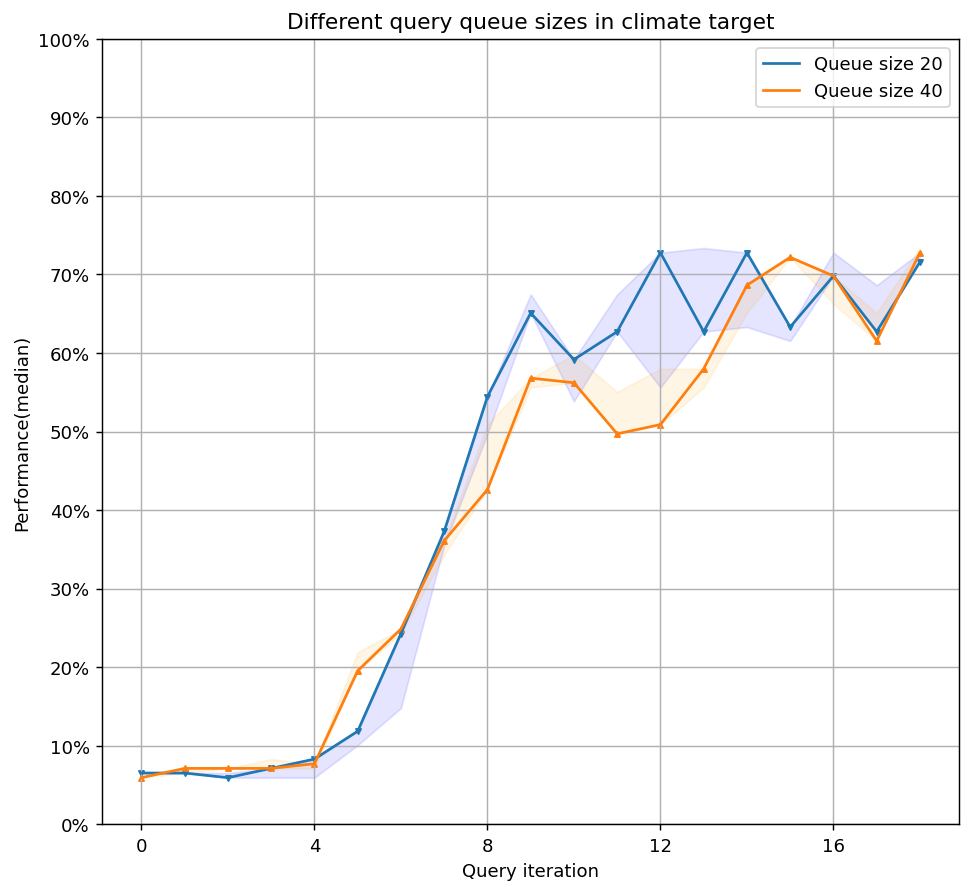

In [49]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_climate1,label="Queue size 20")
ax.fill_between(range(19),min_climate1,max_climate1,color='blue', alpha=0.1)
ax.plot(median_climate2,label="Queue size 40")
ax.fill_between(range(19),min_climate2,max_climate2,color='orange', alpha=0.1)

ax.scatter(range(19), median_climate1, s=8,marker = "v")
ax.scatter(range(19), median_climate2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in climate target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Feminist

In [78]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_feminist)} instances loaded")

val_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_feminist)} instances loaded")

test_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_feminist)} instances loaded")

num_classes = np.unique(train_dataset_feminist['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 597 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 67 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 285 instances loaded


In [79]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [80]:
active_mc_feminist1 = []
mcrun = 0
al_epochs=30
np.random.seed()
n_labeled_examples = np.unique(train_dataset_feminist['text']).size
training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
print(training_indices0)
active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
# # lets randomly label 100 samples, therefore len(active_set) should be 100
active_set_feminist.can_label = False
active_set_feminist.label(training_indices0)
from baal.active import get_heuristic
heuristic = get_heuristic('entropy')
model = model_original
init_weights = deepcopy(model.state_dict())

def compute_metrics(p):
    label = p.label_ids
    preds = np.argmax(p.predictions, axis=-1)
    return {
        'accuracy': accuracy_score(label, preds),
    }
model = BaalTransformersTrainer(
        model=model,
        args=training_args,
        train_dataset=active_set_feminist,
        eval_dataset=valid_set_feminist,
        tokenizer=None,
        compute_metrics=compute_metrics)
active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
model.train()
unqueried_score=model.evaluate()['eval_accuracy']
performance_history_feminist=[unqueried_score]
for epoch in range(al_epochs):
    model.train()
    eval_metrics = model.evaluate()
    should_continue = active_loop_feminist.step()
    model.load_state_dict(init_weights)
    model.lr_scheduler = None
    if not should_continue:
            break
    active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
    }

    logs = {**eval_metrics, **active_logs}
    performance_history_feminist.append(eval_metrics['eval_accuracy'])
print(performance_history_feminist)


[ 40 205 269]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:29:44.644492Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.49it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:29:48.561495Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 40.45it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:29:52.505403Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 40.96it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:29:56.745404Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 38.77it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:01.146447Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 40.17it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:05.802445Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 36.62it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:10.622444Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.56it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:15.596446Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 34.86it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:21.098448Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 37.72it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:26.348448Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 37.17it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:32.150480Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.62it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:38.114195Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 39.29it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:44.059318Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 38.40it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:50.064318Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 36.75it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:30:56.350319Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.87it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:02.933321Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 39.40it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:09.515046Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.51it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:16.038046Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.70it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:22.858131Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.72it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:30.024131Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 37.19it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:37.260132Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.94it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:44.832130Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.52it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:31:52.413131Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.43it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:00.319165Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 39.53it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:08.244945Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:15.970752Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.70it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:24.664754Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.63it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:33.173789Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.67it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:43.218937Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:52.315470Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32.26it/s]


[0.20350877192982456, 0.20350877192982456, 0.20350877192982456, 0.20350877192982456, 0.20350877192982456, 0.2, 0.20701754385964913, 0.25263157894736843, 0.2807017543859649, 0.37543859649122807, 0.2631578947368421, 0.47017543859649125, 0.4, 0.3543859649122807, 0.36140350877192984, 0.37543859649122807, 0.36140350877192984, 0.45964912280701753, 0.5403508771929825, 0.6035087719298246, 0.5614035087719298, 0.3508771929824561, 0.5017543859649123, 0.4421052631578947, 0.41403508771929826, 0.5578947368421052, 0.6385964912280702, 0.6210526315789474, 0.6210526315789474, 0.6175438596491228, 0.6421052631578947]


In [81]:
# median_feminist1, min_feminist1,max_feminist1= calculate(active_mc_feminist1)

In [82]:
active_mc_feminist2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_feminist['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
    print(performance_history_feminist)
    active_mc_feminist2.append(performance_history_feminist)
    mcrun = mcrun + 1

[ 43 543 357]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:32:56.613022Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.12it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:01.659203Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 31.75it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:06.252192Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.68it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:10.783868Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 32.52it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:15.550867Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 30.04it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:21.613391Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.39it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:26.884392Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.22it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:32.510406Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:02<00:00, 25.54it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:39.144936Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.06it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:44.917508Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 36.08it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:51.016561Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.02it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:33:57.567561Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 35.03it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:03.615616Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.86it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:09.667297Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.65it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:16.915792Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.21it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:23.282825Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:29.750683Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 38.13it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:36.577838Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.52it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:43.298372Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:50.272393Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:34:57.241390Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.77it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:04.852714Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.09it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:12.343747Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.68it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:19.856833Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 38.90it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:28.192657Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:36.298913Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.14it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:44.583961Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.78it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:35:52.999953Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.04it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:02.623013Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.88it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:12.292157Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.36it/s]


[0.20350877192982456, 0.19649122807017544, 0.22807017543859648, 0.20701754385964913, 0.22456140350877193, 0.2596491228070175, 0.23859649122807017, 0.28421052631578947, 0.2982456140350877, 0.30526315789473685, 0.3649122807017544, 0.4421052631578947, 0.32280701754385965, 0.4982456140350877, 0.39649122807017545, 0.44912280701754387, 0.5824561403508772, 0.543859649122807, 0.6070175438596491, 0.37894736842105264, 0.519298245614035, 0.5929824561403508, 0.5157894736842106, 0.6105263157894737, 0.6105263157894737, 0.631578947368421, 0.6, 0.5333333333333333, 0.519298245614035, 0.6210526315789474, 0.6421052631578947]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:15.864157Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.33it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:20.222160Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.51it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:24.815041Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.29it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:29.600042Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 33.55it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:34.474042Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 34.52it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:39.457041Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 36.69it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:44.303045Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.89it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:49.550040Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.12it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:36:54.941128Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.90it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:00.529157Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 35.96it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:06.513157Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.27it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:12.471158Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 36.29it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:18.510089Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 35.71it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:24.639881Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 35.62it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:30.940774Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.03it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:37.540776Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 36.36it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:44.345413Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 36.88it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:51.487644Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:37:58.519582Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:05.671581Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:13.072659Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.09it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:20.475138Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.18it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:28.055141Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.56it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:35.930645Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.69it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:43.929646Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.50it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:38:51.932617Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.38it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:00.287614Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.74it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:08.658730Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 39.33it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:17.281731Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:25.883732Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.22it/s]


[0.21052631578947367, 0.21403508771929824, 0.22456140350877193, 0.20701754385964913, 0.24210526315789474, 0.2771929824561403, 0.2912280701754386, 0.29473684210526313, 0.3368421052631579, 0.3368421052631579, 0.3684210526315789, 0.43508771929824563, 0.312280701754386, 0.4105263157894737, 0.5543859649122806, 0.48771929824561405, 0.4421052631578947, 0.5017543859649123, 0.519298245614035, 0.5684210526315789, 0.3894736842105263, 0.5684210526315789, 0.4105263157894737, 0.512280701754386, 0.624561403508772, 0.5263157894736842, 0.6, 0.5649122807017544, 0.6, 0.5614035087719298, 0.6140350877192983]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:29.380731Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 36.07it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:33.518885Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 36.73it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:37.774887Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 35.19it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:42.209251Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 34.29it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:46.881331Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 35.91it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:51.677329Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 35.19it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:39:56.711331Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.34it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:01.870332Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.21it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:07.249328Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 36.23it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:12.695329Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 34.51it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:18.387371Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.49it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:24.372372Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 36.52it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:30.389746Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 36.38it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:36.533832Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.62it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:42.870836Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.07it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:49.447835Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 35.78it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:40:56.278838Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.31it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:03.007837Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.82it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:10.391612Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:17.503620Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 38.68it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:24.785650Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 39.12it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:32.386623Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.60it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:39.965621Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:48.221662Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 35.20it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:41:56.156033Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.54it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:04.207032Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.50it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:12.621652Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:21.167653Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.89it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:29.805678Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:38.768677Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 38.46it/s]


[0.21052631578947367, 0.21403508771929824, 0.22456140350877193, 0.20701754385964913, 0.24210526315789474, 0.2771929824561403, 0.2912280701754386, 0.29473684210526313, 0.3368421052631579, 0.3368421052631579, 0.3684210526315789, 0.43508771929824563, 0.312280701754386, 0.4105263157894737, 0.5543859649122806, 0.48771929824561405, 0.4421052631578947, 0.5017543859649123, 0.519298245614035, 0.5684210526315789, 0.3894736842105263, 0.5684210526315789, 0.4105263157894737, 0.512280701754386, 0.624561403508772, 0.5263157894736842, 0.6, 0.5649122807017544, 0.6, 0.5614035087719298, 0.6140350877192983]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:42.178484Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 35.03it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:46.292480Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 36.13it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:50.594479Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 36.52it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:54.973479Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 35.39it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:42:59.473479Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 34.04it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:04.335757Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 35.84it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:09.429761Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.63it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:14.588757Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 34.63it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:20.076130Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 36.16it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:25.590130Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 34.50it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:31.167161Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.08it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:37.129159Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 36.10it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:43.120159Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.43it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:49.352157Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 35.62it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:43:55.721159Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.36it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:02.161159Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.64it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:09.025200Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 36.88it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:15.878201Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.16it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:23.028986Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.28it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:30.222088Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.53it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:37.625087Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.40it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:45.116087Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.06it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:44:52.674090Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:00.494087Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 36.80it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:08.366087Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.27it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:16.497255Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.81it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:24.801254Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:33.255253Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.90it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:41.869255Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.72it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:50.554281Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.82it/s]


[0.21052631578947367, 0.21403508771929824, 0.22456140350877193, 0.20701754385964913, 0.24210526315789474, 0.2771929824561403, 0.2912280701754386, 0.29473684210526313, 0.3368421052631579, 0.3368421052631579, 0.3684210526315789, 0.43508771929824563, 0.312280701754386, 0.4105263157894737, 0.5543859649122806, 0.48771929824561405, 0.4421052631578947, 0.5017543859649123, 0.519298245614035, 0.5684210526315789, 0.3894736842105263, 0.5684210526315789, 0.4105263157894737, 0.512280701754386, 0.624561403508772, 0.5263157894736842, 0.6, 0.5649122807017544, 0.6, 0.5614035087719298, 0.6140350877192983]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:53.984285Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 34.75it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:45:58.143348Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 34.95it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:02.489379Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 35.99it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:06.956348Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 36.83it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:11.697394Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 35.25it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:16.450397Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 35.01it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:21.488395Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.41it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:26.714397Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 36.38it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:32.071395Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 36.35it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:37.615396Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 35.21it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:43.336395Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.20it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:49.122808Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.76it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:46:55.145808Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 36.41it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:01.305808Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 35.53it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:07.685822Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.13it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:14.406820Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 35.48it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:21.028778Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.12it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:27.991779Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.24it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:34.937779Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.08it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:42.385480Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:49.722449Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.82it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:47:57.307480Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:04.952475Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.31it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:12.766480Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 36.80it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:20.759547Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.41it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:29.235202Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.25it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:37.531201Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.77it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:46.154069Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:48:54.844069Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.00it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[10616-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-28T15:49:03.804100Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.00it/s]


[0.21052631578947367, 0.21403508771929824, 0.22456140350877193, 0.20701754385964913, 0.24210526315789474, 0.2771929824561403, 0.2912280701754386, 0.29473684210526313, 0.3368421052631579, 0.3368421052631579, 0.3684210526315789, 0.43508771929824563, 0.312280701754386, 0.4105263157894737, 0.5543859649122806, 0.48771929824561405, 0.4421052631578947, 0.5017543859649123, 0.519298245614035, 0.5684210526315789, 0.3894736842105263, 0.5684210526315789, 0.4105263157894737, 0.512280701754386, 0.624561403508772, 0.5263157894736842, 0.6, 0.5649122807017544, 0.6, 0.5614035087719298, 0.6140350877192983]


In [83]:
median_feminist2, min_feminist2,max_feminist2= calculate(active_mc_feminist2)

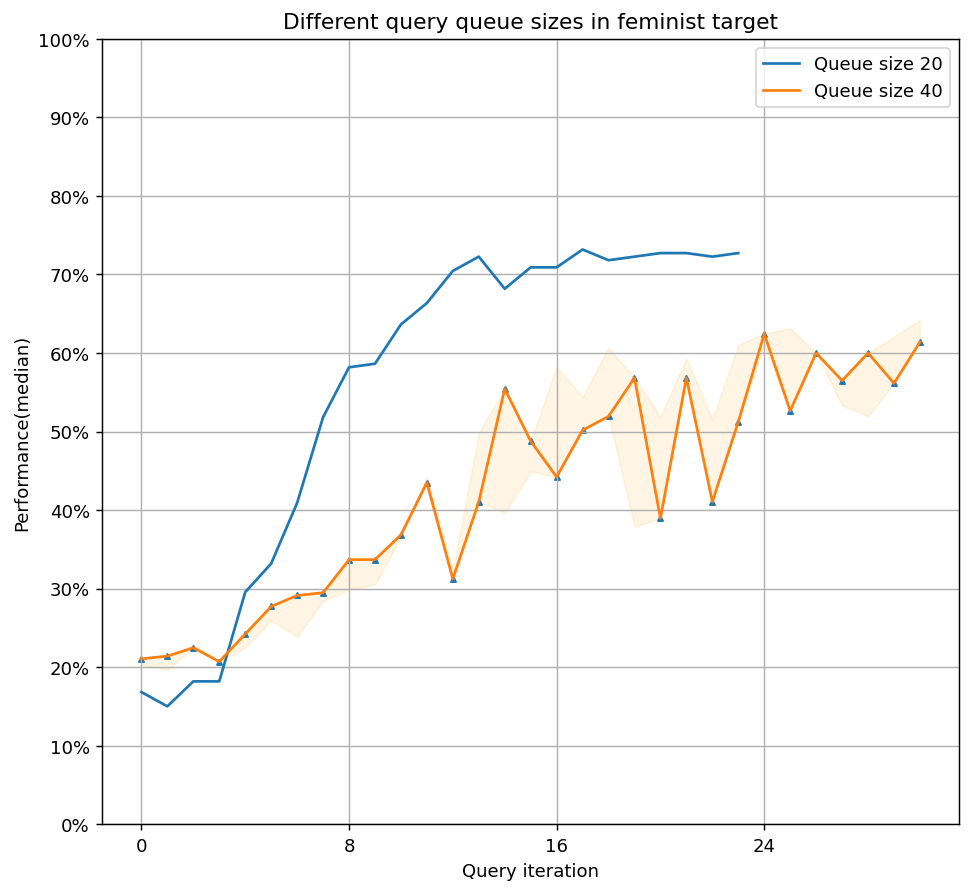

In [85]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(performance_history_atheism,label="Queue size 20")
# ax.fill_between(range(31),min_feminist1,max_feminist1,color='blue', alpha=0.1)
ax.plot(median_feminist2,label="Queue size 40")
ax.fill_between(range(31),min_feminist2,max_feminist2,color='orange', alpha=0.1)

# ax.scatter(range(31), median_feminist1, s=8,marker = "v")
ax.scatter(range(31), median_feminist2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in feminist target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Hillary

In [8]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_hillary)} instances loaded")

val_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_hillary)} instances loaded")

test_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_hillary)} instances loaded")

num_classes = np.unique(train_dataset_hillary['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 620 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 69 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 295 instances loaded


In [9]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [10]:
active_mc_hillary1 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_hillary['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = model_original
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
    print(performance_history_hillary)
    active_mc_hillary1.append(performance_history_hillary)
    mcrun = mcrun + 1

[332  52  10]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:44:35.884352Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.56it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:44:39.875890Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.99it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:44:46.009162Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 40.19it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:44:52.134946Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 38.70it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:44:59.508671Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 40.47it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:04.494484Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 40.87it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:11.243055Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 40.49it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:16.021731Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.77it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:21.245937Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 38.33it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:27.333447Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 39.85it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:33.085696Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.97it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:39.228546Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.69it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:45.568250Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 39.82it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:52.012445Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 41.14it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:45:58.458939Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 36.66it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:05.266672Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:11.811585Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 43.23it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:18.346868Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.93it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:25.150167Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.61it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:32.636588Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.41it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:40.628379Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.63it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:48.415399Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 36.08it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:46:56.575050Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:04.478543Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.28it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:12.090150Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 46.88it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:19.669761Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.32it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:27.523527Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 46.31it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:35.497941Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:43.994763Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.78it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:52.874732Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.09it/s]


[0.2677966101694915, 0.2677966101694915, 0.31864406779661014, 0.31186440677966104, 0.34576271186440677, 0.38305084745762713, 0.488135593220339, 0.488135593220339, 0.4135593220338983, 0.5254237288135594, 0.4440677966101695, 0.5016949152542373, 0.559322033898305, 0.5728813559322034, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:56.057393Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 42.84it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:47:59.819952Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 41.21it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:05.118802Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 43.95it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:09.479988Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 43.81it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:13.485021Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 43.61it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:17.980295Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 43.63it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:22.425504Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 42.14it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:27.321877Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.82it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:32.173762Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 43.70it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:37.008675Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 43.41it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:42.289312Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.33it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:47.641714Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.93it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:53.221096Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 41.95it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:48:59.109889Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 42.28it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:05.248437Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 41.54it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:11.381682Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 42.25it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:17.674458Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.20it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:23.966185Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.14it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:30.676216Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 39.40it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:37.539486Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.04it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:44.530313Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 41.76it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:51.911201Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 41.74it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:49:59.242772Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 47.58it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:06.481577Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.76it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:13.927290Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 45.60it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:21.540372Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.61it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:29.313008Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 45.83it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:37.244941Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.35it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:45.914686Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.10it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:54.290045Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.12it/s]


[0.28135593220338984, 0.28135593220338984, 0.3050847457627119, 0.3016949152542373, 0.3559322033898305, 0.34576271186440677, 0.3559322033898305, 0.43728813559322033, 0.4440677966101695, 0.4915254237288136, 0.559322033898305, 0.5423728813559322, 0.5728813559322034, 0.5491525423728814, 0.5932203389830508, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:50:57.628331Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.72it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:01.501824Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 39.45it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:05.522382Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 42.15it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:09.555953Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 41.39it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:14.010352Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 42.63it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:18.235938Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 41.32it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:22.801077Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 44.68it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:27.476693Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.38it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:32.470828Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 43.50it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:37.395156Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 42.15it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:42.664576Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.54it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:48.445224Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.38it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:53.835548Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 43.30it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:51:59.467082Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 42.55it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:05.430060Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 44.24it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:11.387205Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 42.51it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:17.834088Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 44.37it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:24.555206Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.48it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:31.624191Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 41.94it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:38.482310Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.80it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:45.433006Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 43.43it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:52:52.429153Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 40.02it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:00.164870Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.82it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:07.500758Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 44.70it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:15.118548Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 44.32it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:23.177321Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.93it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:31.047059Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 49.12it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:39.073099Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.07it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:47.323630Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.64it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:55.683544Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.06it/s]


[0.28135593220338984, 0.28135593220338984, 0.3050847457627119, 0.3016949152542373, 0.3559322033898305, 0.34576271186440677, 0.3559322033898305, 0.43728813559322033, 0.4440677966101695, 0.4915254237288136, 0.559322033898305, 0.5423728813559322, 0.5728813559322034, 0.5491525423728814, 0.5932203389830508, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:53:58.751457Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.88it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:02.766801Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 44.23it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:06.376074Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 44.02it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:10.304433Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 43.81it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:14.397060Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 45.47it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:18.423554Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 44.13it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:22.824001Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 43.33it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:27.532676Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.31it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:32.362652Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 42.69it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:37.240767Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 42.48it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:42.466805Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.39it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:47.539828Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.44it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:52.923152Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 45.44it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:54:58.591083Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 42.19it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:04.497949Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 43.05it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:10.350706Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 45.84it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:16.533732Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.12it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:23.265620Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.98it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:29.716787Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 45.49it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:36.592311Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.81it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:43.473158Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 44.07it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:50.446272Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 41.18it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:55:58.174426Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 44.58it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:05.682305Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.39it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:13.183318Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 43.00it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:20.758108Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.90it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:28.431012Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 48.27it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:36.381874Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.96it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:44.526654Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.48it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:53.307944Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.93it/s]


[0.28135593220338984, 0.28135593220338984, 0.3050847457627119, 0.3016949152542373, 0.3559322033898305, 0.34576271186440677, 0.3559322033898305, 0.43728813559322033, 0.4440677966101695, 0.4915254237288136, 0.559322033898305, 0.5423728813559322, 0.5728813559322034, 0.5491525423728814, 0.5932203389830508, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:56:56.924934Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 41.20it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:00.539142Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 42.84it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:04.225511Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 41.18it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:08.296042Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 43.12it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:12.379061Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 43.59it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:16.631183Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 42.62it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:21.141767Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 41.58it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:25.795767Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.15it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:30.745214Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 42.74it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:35.806357Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 41.02it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:41.064163Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.11it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:46.444269Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.14it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:52.010209Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 43.33it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:57:57.653914Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 42.23it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:03.385370Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 42.98it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:09.424538Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.32it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:15.793768Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 42.77it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:22.179591Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.98it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:29.206910Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 41.94it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:35.962501Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.61it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:42.826503Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 45.61it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:49.987237Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 42.30it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:58:57.586345Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.46it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:05.879938Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.17it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:14.272352Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 41.84it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:22.465831Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.75it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:30.759677Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 43.92it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:39.765904Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.49it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:48.620032Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.21it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T15:59:57.651255Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.84it/s]


[0.28135593220338984, 0.28135593220338984, 0.3050847457627119, 0.3016949152542373, 0.3559322033898305, 0.34576271186440677, 0.3559322033898305, 0.43728813559322033, 0.4440677966101695, 0.4915254237288136, 0.559322033898305, 0.5423728813559322, 0.5728813559322034, 0.5491525423728814, 0.5932203389830508, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]


In [11]:
median_hillary1, min_hillary1,max_hillary1 = calculate(active_mc_hillary1)

In [12]:
active_mc_hillary2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_hillary['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
    print(performance_history_hillary)
    active_mc_hillary2.append(performance_history_hillary)
    mcrun = mcrun + 1

[476 577  59]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:01.923396Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.89it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:06.197308Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 33.78it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:10.927265Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 35.91it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:15.515921Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.00it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:20.702669Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.62it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:26.298152Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 28.25it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:31.754269Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.81it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:37.090082Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.00it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:42.882589Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.22it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:48.741983Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.27it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:00:54.712977Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.08it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:00.962295Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:07.285507Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.42it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:13.940739Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.51it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:20.771647Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.64it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:27.097362Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:33.927879Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.98it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:40.990050Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:48.040387Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.36it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:01:55.328413Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.74it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:03.073087Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:10.717274Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:18.571592Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.04it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:26.637001Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:34.885095Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.19it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:42.959294Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.80it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:02:52.056577Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.33it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:01.254121Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.11it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:10.482546Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.10it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:19.454236Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.53it/s]


[0.3389830508474576, 0.3254237288135593, 0.39322033898305087, 0.4101694915254237, 0.46440677966101696, 0.4271186440677966, 0.5322033898305085, 0.5254237288135594, 0.5559322033898305, 0.5254237288135594, 0.5728813559322034, 0.5457627118644067, 0.5728813559322034, 0.5423728813559322, 0.576271186440678, 0.5661016949152542, 0.5864406779661017, 0.5627118644067797, 0.5796610169491525, 0.5661016949152542, 0.5728813559322034, 0.5661016949152542, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5694915254237288, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:22.996932Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.14it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:27.145275Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 35.86it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:31.425143Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.85it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:36.310015Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.79it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:41.524102Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 36.33it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:46.386391Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 35.37it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:51.369841Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 36.47it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:03:56.485204Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.80it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:01.854817Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 38.17it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:07.224030Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.24it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:13.016433Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.54it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:18.933930Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.66it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:25.577904Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.84it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:31.589905Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 36.57it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:37.891985Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:44.896823Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.79it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:04:52.056867Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 37.01it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:00.239473Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.37it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:07.761920Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:15.199670Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:22.909069Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.72it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:30.893782Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.26it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:38.473300Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.93it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:47.026106Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:05:55.516809Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.75it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:04.648803Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.72it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:13.374097Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.61it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:21.830117Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.84it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:30.795980Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.53it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:40.528813Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.87it/s]


[0.30847457627118646, 0.29152542372881357, 0.376271186440678, 0.3864406779661017, 0.38305084745762713, 0.4101694915254237, 0.5016949152542373, 0.5050847457627119, 0.5254237288135594, 0.49491525423728816, 0.5864406779661017, 0.5152542372881356, 0.5796610169491525, 0.5322033898305085, 0.5796610169491525, 0.5627118644067797, 0.5864406779661017, 0.5728813559322034, 0.576271186440678, 0.5796610169491525, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:44.178897Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.65it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:48.414721Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 36.42it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:52.628700Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 38.07it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:06:57.004161Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.68it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:02.550626Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 25.41it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:09.410156Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 21.30it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:17.098706Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.67it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:23.995384Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.63it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:30.031049Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.06it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:35.552806Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 35.51it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:41.264357Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.15it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:47.039082Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.39it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:52.946280Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.64it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:07:59.051428Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 37.92it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:05.195908Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 35.18it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:11.702998Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.65it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:19.226487Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 30.73it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:26.562520Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.11it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:34.509987Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.06it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:42.342375Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.37it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:49.866773Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.06it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:08:57.673008Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.05it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:05.494241Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.68it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:13.600472Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.87it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:22.310971Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 37.99it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:30.805948Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 26.46it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:40.710848Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.85it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:09:51.060964Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.34it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:01.393735Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.41it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:10.463796Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.37it/s]


[0.30847457627118646, 0.29152542372881357, 0.376271186440678, 0.3864406779661017, 0.38305084745762713, 0.4101694915254237, 0.5016949152542373, 0.5050847457627119, 0.5254237288135594, 0.49491525423728816, 0.5864406779661017, 0.5152542372881356, 0.5796610169491525, 0.5322033898305085, 0.5796610169491525, 0.5627118644067797, 0.5864406779661017, 0.5728813559322034, 0.576271186440678, 0.5796610169491525, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:14.235723Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.76it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:18.284130Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 37.34it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:22.399421Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.32it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:27.290136Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.67it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:31.854941Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.58it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:36.431770Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 37.69it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:41.129444Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.67it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:45.981297Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.86it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:51.339031Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.94it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:10:56.818151Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 36.55it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:02.924783Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:09.022507Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.21it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:15.282030Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.83it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:21.584806Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.28it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:28.283918Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.08it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:34.993510Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.98it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:41.901662Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.85it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:49.080111Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35.25it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:11:56.740909Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.64it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:04.154579Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.78it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:11.626284Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:19.356945Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.16it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:27.353590Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.25it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:35.471435Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.82it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:43.798382Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.51it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:12:52.116077Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.55it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:00.888862Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.28it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:09.659011Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.63it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:18.629060Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.56it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:27.934006Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.93it/s]


[0.30847457627118646, 0.29152542372881357, 0.376271186440678, 0.3864406779661017, 0.38305084745762713, 0.4101694915254237, 0.5016949152542373, 0.5050847457627119, 0.5254237288135594, 0.49491525423728816, 0.5864406779661017, 0.5152542372881356, 0.5796610169491525, 0.5322033898305085, 0.5796610169491525, 0.5627118644067797, 0.5864406779661017, 0.5728813559322034, 0.576271186440678, 0.5796610169491525, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:31.482382Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.88it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:35.723668Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 31.95it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:40.286697Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 34.69it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:44.856760Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 34.09it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:49.669921Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.81it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:13:54.741516Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 32.37it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:00.129220Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.97it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:05.809742Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:11.358923Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.43it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:16.814913Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 38.41it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:22.220989Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.01it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:27.741680Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.67it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:33.403293Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 38.82it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:39.194623Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 37.98it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:45.211783Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 38.79it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:51.311819Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.91it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:14:57.847121Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.82it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:04.337791Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 38.08it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:11.015095Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.17it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:17.922830Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.49it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:24.831184Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 37.49it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:32.036881Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.34it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:39.472481Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.30it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:47.223386Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.01it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:15:54.801158Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 39.03it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:16:02.831933Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.38it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:16:11.075149Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.92it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:16:20.314137Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.21it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:16:29.137249Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.65it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[316-MainThread  ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T16:16:38.210900Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.88it/s]


[0.30847457627118646, 0.29152542372881357, 0.376271186440678, 0.3864406779661017, 0.38305084745762713, 0.4101694915254237, 0.5016949152542373, 0.5050847457627119, 0.5254237288135594, 0.49491525423728816, 0.5864406779661017, 0.5152542372881356, 0.5796610169491525, 0.5322033898305085, 0.5796610169491525, 0.5627118644067797, 0.5864406779661017, 0.5728813559322034, 0.576271186440678, 0.5796610169491525, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271]


In [13]:
median_hillary2, min_hillary2,max_hillary2= calculate(active_mc_hillary2)

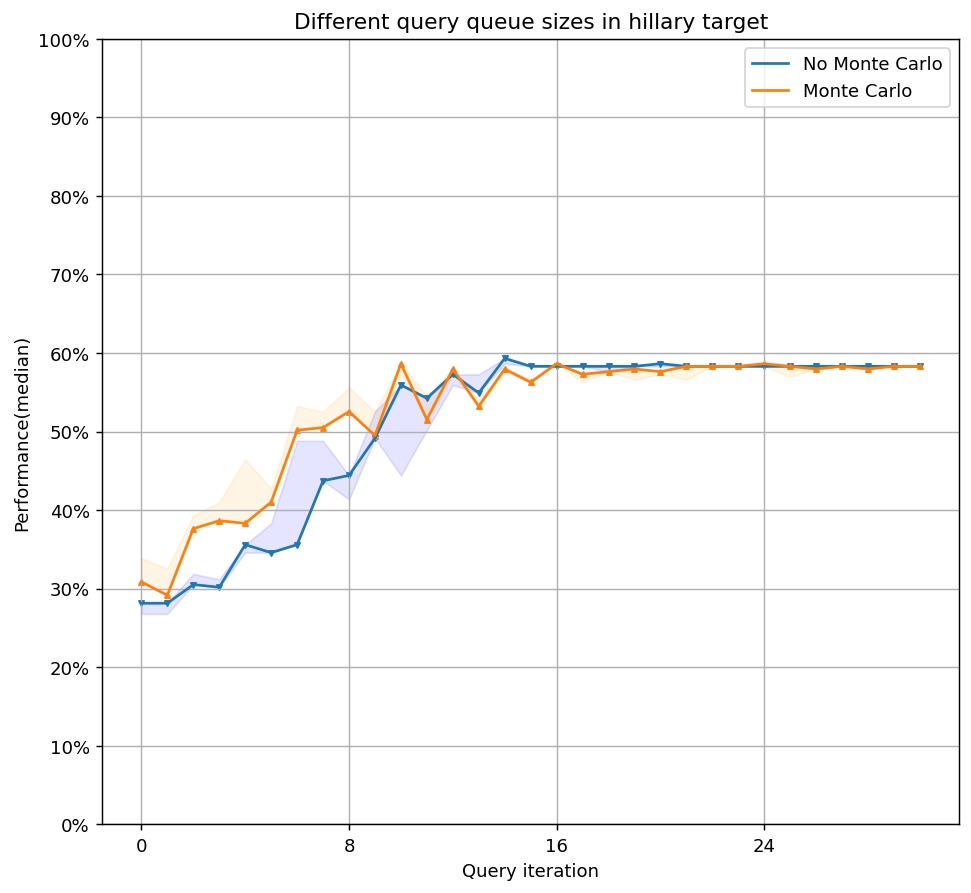

In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_hillary1,label="No Monte Carlo")
ax.fill_between(range(31),min_hillary1,max_hillary1,color='blue', alpha=0.1)
ax.plot(median_hillary2,label="Monte Carlo")
ax.fill_between(range(31),min_hillary2,max_hillary2,color='orange', alpha=0.1)


ax.scatter(range(31), median_hillary1, s=8,marker = "v")
ax.scatter(range(31), median_hillary2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in hillary target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()